In [1]:
# 1 Imports
import pandas as pd
import numpy as np
from sklearn import svm
from keras import Sequential
from keras import layers
from keras.models import clone_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler
import matplotlib.pyplot as plt

In [ ]:
# TODO List
    # create models
    # train models
    # make predictions and perform validation
    # robust visuals

In [2]:
# 2 Load Datasets
df_nlr = pd.read_csv("raw_nuclear/nlr.csv")
df_ura = pd.read_csv("raw_nuclear/ura.csv")
df_crak = pd.read_csv("raw_oil_and_gas/crak.csv")
df_fcg = pd.read_csv("raw_oil_and_gas/fcg.csv")
df_pxe = pd.read_csv("raw_oil_and_gas/pxe.csv")
df_icln = pd.read_csv("raw_renewable/icln.csv")
df_smog = pd.read_csv("raw_renewable/smog.csv")
df_tan = pd.read_csv("raw_renewable/tan.csv")

repaired_col = "Repaired?"
df_nlr = df_nlr.drop(columns=[repaired_col]).fillna(0)
df_ura = df_ura.drop(columns=[repaired_col]).fillna(0)
df_crak = df_crak.drop(columns=[repaired_col]).fillna(0)
df_fcg = df_fcg.drop(columns=[repaired_col]).fillna(0)
df_pxe = df_pxe.drop(columns=[repaired_col]).fillna(0)
df_icln = df_icln.drop(columns=[repaired_col]).fillna(0)
df_smog = df_smog.drop(columns=[repaired_col]).fillna(0)
df_tan = df_tan.drop(columns=[repaired_col]).fillna(0)

df_nlr = df_nlr.drop(columns=["Date"]).fillna(0)
df_ura = df_ura.drop(columns=["Date"]).fillna(0)
df_crak = df_crak.drop(columns=["Date"]).fillna(0)
df_fcg = df_fcg.drop(columns=["Date"]).fillna(0)
df_pxe = df_pxe.drop(columns=["Date"]).fillna(0)
df_icln = df_icln.drop(columns=["Date"]).fillna(0)
df_smog = df_smog.drop(columns=["Date"]).fillna(0)
df_tan = df_tan.drop(columns=["Date"]).fillna(0)

df_nlr_close = df_nlr[["Close"]]
df_ura_close = df_ura[["Close"]]

In [4]:
# 3 Create time frame based subsets
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

def time_based_subsets(df):
    subsets = []
    #row 2013 is the last date of 2023, 12/29/2023
    #row 756 is start of 2019
    #row 505 is start of 2018
    #row 254 is start of 2017
    #row 2 is start of 2016
    #all of these -2 bc 0 indexing and bc title row already seperated out in pd df
    subsets.append(df[0:2012]) #8 year time frame
    subsets.append(df[252:2012]) #7 year time frame
    subsets.append(df[503:2012]) #6 year time frame
    subsets.append(df[754:2012]) #5 year time frame
    subsets.append(df[2012:2262]) # 2024 only
    X, y = [], []
    x1, y1 = create_sequences(subsets[0], 30)
    x1 = x1.reshape((x1.shape[0], x1.shape[1], 6))
    x2, y2 = create_sequences(subsets[1], 30)
    x2 = x2.reshape((x2.shape[0], x2.shape[1], 6))
    x3, y3 = create_sequences(subsets[2], 30)
    x3 = x3.reshape((x3.shape[0], x3.shape[1], 6))
    x4, y4 = create_sequences(subsets[3], 30)
    x4 = x4.reshape((x4.shape[0], x4.shape[1], 6))
    x5, y5 = create_sequences(subsets[4], 30)
    x5 = x5.reshape((x5.shape[0], x5.shape[1], 6))
    X.append(x1)
    X.append(x2)
    X.append(x3)
    X.append(x4)
    X.append(x5)
    y.append(y1)
    y.append(y2)
    y.append(y3)
    y.append(y4)
    y.append(y5)
    return subsets, X, y

scaler = StandardScaler()
scaled_ura = scaler.fit_transform(df_ura)
ura_sets, ura_X, ura_y = time_based_subsets(scaled_ura)
'''scaled_ura = scaler.fit_transform(df_ura)
scaled_nlr = scaler.transform(df_nlr)
nlr_sets, nlr_X, nlr_y = time_based_subsets(scaled_nlr)
ura_sets, ura_X, ura_y = time_based_subsets(scaled_ura)
combined_X, combined_y = [], []
combined_X.append(np.concatenate((nlr_X[0], ura_X[0])))
combined_X.append(np.concatenate((nlr_X[1], ura_X[1])))
combined_X.append(np.concatenate((nlr_X[2], ura_X[2])))
combined_X.append(np.concatenate((nlr_X[3], ura_X[3])))
combined_X.append(np.concatenate((nlr_X[4], ura_X[4])))
combined_y.append(np.concatenate((nlr_y[0], ura_y[0])))
combined_y.append(np.concatenate((nlr_y[1], ura_y[1])))
combined_y.append(np.concatenate((nlr_y[2], ura_y[2])))
combined_y.append(np.concatenate((nlr_y[3], ura_y[3])))
combined_y.append(np.concatenate((nlr_y[4], ura_y[4])))'''
'''crak_sets, crak_X, crak_y = time_based_subsets(df_crak)
fcg_sets, fcg_X, fcg_y = time_based_subsets(df_fcg)
pxe_sets, pxe_X, pxe_y = time_based_subsets(df_pxe)
icln_sets, icln_X, icln_y = time_based_subsets(df_icln)
smog_sets, smog_X, smog_y = time_based_subsets(df_smog)
tan_sets, tan_X, tan_y = time_based_subsets(df_tan)'''



'crak_sets, crak_X, crak_y = time_based_subsets(df_crak)\nfcg_sets, fcg_X, fcg_y = time_based_subsets(df_fcg)\npxe_sets, pxe_X, pxe_y = time_based_subsets(df_pxe)\nicln_sets, icln_X, icln_y = time_based_subsets(df_icln)\nsmog_sets, smog_X, smog_y = time_based_subsets(df_smog)\ntan_sets, tan_X, tan_y = time_based_subsets(df_tan)'

In [5]:
# 4 Initial Model Setup
svm_model = svm.SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)

gru_model = Sequential()
gru_model.add(layers.GRU(units=128, activation='tanh', input_shape=(30, 6))) # GRU layer
gru_model.add(layers.Dense(units=6))
gru_model.compile(optimizer='adam', loss='mse')

C:\Users\david\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [6]:
# 5 Model Training
gru_nlr = clone_model(gru_model)
gru_nlr.compile(optimizer='adam',loss='mse')
gru_ura = clone_model(gru_model)
gru_ura.compile(optimizer='adam',loss='mse')
'''gru_nlr.fit(
    nlr_X[0], nlr_y[0],
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)'''
gru_ura.fit(
    ura_X[0], ura_y[0],
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)
'''gru_nlr.fit(
    combined_X[0], combined_y[0],
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)'''

Epoch 1/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.1691 - val_loss: 0.0732
Epoch 2/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0419 - val_loss: 0.0762
Epoch 3/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0352 - val_loss: 0.0776
Epoch 4/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0296 - val_loss: 0.0688
Epoch 5/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0304 - val_loss: 0.0695
Epoch 6/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0303 - val_loss: 0.0725
Epoch 7/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0268 - val_loss: 0.0817
Epoch 8/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0335 - val_loss: 0.0678
Epoch 9/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0263 - val_loss: 0.0682
Epoch 10/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0312 - val_loss: 0.0743
Epoch 11/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0296 - val_loss: 0.0659
Epoch 12/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step

'gru_nlr.fit(\n    combined_X[0], combined_y[0],\n    epochs=100,\n    batch_size=32,\n    validation_split=0.1,\n    verbose=1\n)'

In [7]:
# 6 make predictions
# this receives a list of models, and it will take the average of their predictions
# it can also be passed a single model
def predict_future_points(models,last_seq, num_predictions=20):
    current_sequence = np.array(last_seq)

    current_sequence = current_sequence.reshape(1, current_sequence.shape[0], current_sequence.shape[1])

    predictions = []

    for _ in range(num_predictions):
        next_pred_sum = []
        next_pred_scaled_sum = []
        for i in range(len(models)):
            next_pred_scaled = models[i].predict(current_sequence, verbose=0)
            next_pred = scaler.inverse_transform(next_pred_scaled)
            next_pred_scaled_sum.append(next_pred_scaled)
            next_pred_sum.append(next_pred)
        next_pred_average = np.zeros(next_pred_sum[0].shape)
        next_pred_scaled_average = np.zeros(next_pred_scaled_sum[0].shape)
        for j in range(len(next_pred_sum[0][0])):
            for k in range(len(next_pred_sum)):
                next_pred_average[0][j] += next_pred_sum[k][0][j] #add value of all models for each value before going to next val
                next_pred_scaled_average[0][j] += next_pred_scaled_sum[k][0][j]
            next_pred_average[0][j] = next_pred_average[0][j]/len(next_pred_sum)
            next_pred_scaled_average[0][j] = next_pred_scaled_average[0][j]/len(next_pred_sum)
        predictions.append(next_pred_average)

        current_sequence = np.concatenate(
            [current_sequence[:,1:,:], [next_pred_scaled_average]], axis=1
        )


    return predictions

last_seq = ura_sets[0][-30:]
future = predict_future_points([gru_ura],last_seq, 250)


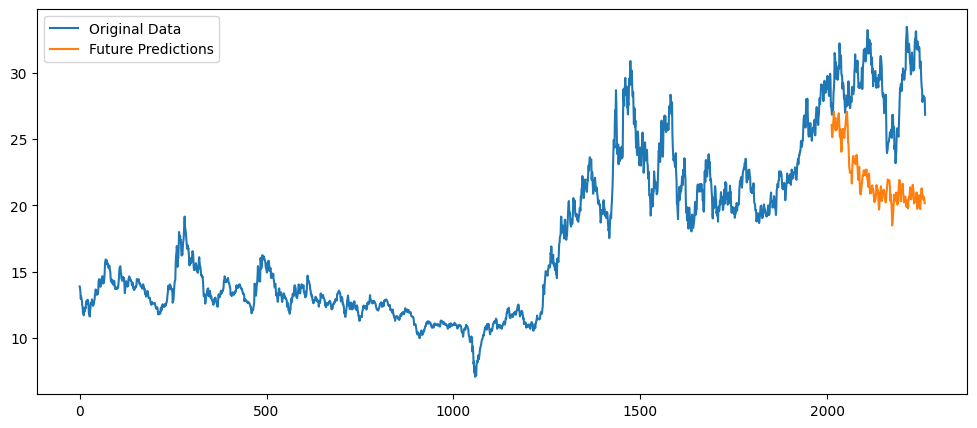

In [8]:
future_feature = np.array([arr[0][3] for arr in future])
plt.figure(figsize=(12,5))
plt.plot(df_ura['Close'], label="Original Data")
plt.plot(range(2012, 2012 + len(future)), future_feature, label="Future Predictions")
plt.legend()
plt.show()